# Set up libraries

In [504]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb

In [505]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.", category=UserWarning)
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.", category=UserWarning)

# Load Data

In [506]:
calls = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Service Queue Data.csv')
calls['Date'] = pd.to_datetime(calls['Date'])
calls.set_index('Date', inplace=True)  

calls = calls.rename(columns={'Unmatched callers' : 'unmatched_callers'})

In [507]:
occupancy = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv')

occupancy['OCCUPANCY_DATE'] = pd.to_datetime(occupancy['OCCUPANCY_DATE'])
occupancy.set_index('_id', inplace=True, drop=True)

occupancy.set_index('OCCUPANCY_DATE', inplace=True)
monthly_average_occupancy_rate = occupancy['OCCUPANCY_RATE_BEDS'].resample('MS').mean()

In [508]:
shelter_flow = pd.read_csv('/Users/pendovka/Desktop/Data/toronto-shelter-system-flow.csv')
shelter_flow.rename(columns={'date(mmm-yy)': 'Date'}, inplace=True)
shelter_flow['Date'] = pd.to_datetime(shelter_flow['Date'], format='%b-%y')
shelter_flow = shelter_flow.set_index('Date')

In [509]:
calls_full = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Call Wrap-Up Codes Data.csv')
calls_full['Date'] = pd.to_datetime(calls_full['Date'])
calls_full.set_index('Date', inplace=True)
calls_full.rename(columns={'Code 3B - Shelter Space Unavailable - Individuals/Couples': 'shelter_unavailable_ind'}, inplace=True)
calls_full.rename(columns={'Total calls handled': 'total_calls_handled'}, inplace=True)

In [442]:
weather20 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_20.csv')
weather21 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_21.csv')
weather22 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_22.csv')
weather23 = pd.read_csv('/Users/pendovka/Desktop/Data/toronto_weather_23.csv')

weather = pd.concat([weather20, weather21, weather22, weather23])

weather = weather.rename(columns={'Date/Time': 'Date', 'Min Temp (°C)': 'min_temp_cels', 'Total Precip (mm)': 'total_precip_mm'})

weather['Date'] = pd.to_datetime(weather['Date']) 
weather.set_index('Date', inplace=True)

weather = weather[['min_temp_cels', 'total_precip_mm']]
weather['min_temp_cels'] = weather['min_temp_cels'].interpolate(method='linear')
weather['total_precip_mm'] = weather['total_precip_mm'].interpolate(method='linear')

weather['day_of_week'] = weather.index.dayofweek
dummy_variables = pd.get_dummies(weather['day_of_week'], prefix='day')
dummy_variables = dummy_variables.astype(int)

dummy_variables = dummy_variables.drop(columns='day_0')

weather = pd.concat([weather, dummy_variables], axis=1)

# Merge Tables on the Monthly Basis

In [511]:
average_daily_calls_unavailable = calls_full['shelter_unavailable_ind'].resample('MS').mean()
average_daily_total_calls = calls_full['total_calls_handled'].resample('MS').mean().rename('average_daily_total_calls')

monthly_calls = pd.merge(average_daily_calls_unavailable, average_daily_total_calls, on='Date', how='inner')
monthly_calls['unavailable_ratio'] = monthly_calls['shelter_unavailable_ind'] / monthly_calls['average_daily_total_calls']

shelter_flow = shelter_flow[shelter_flow['population_group'] == 'All Population']

average_daily_unmatched = calls['unmatched_callers'].resample('MS').mean().rename('average_daily_unmatched_callers')
monthly_calls_merge = pd.merge(monthly_calls, average_daily_unmatched , on= 'Date', how='inner')

In [ ]:
merged_calls_flow_monthly = pd.merge(monthly_calls_merge, shelter_flow, left_index=True, right_index=True, how='inner')

merged_calls_flow_monthly = merged_calls_flow_monthly[merged_calls_flow_monthly.index.year < 2024]

merged_calls_flow_monthly.reset_index(inplace=True)

merged_calls_flow_monthly = merged_calls_flow_monthly[['Date', 'average_daily_total_calls', 'average_daily_unmatched_callers', 'newly_identified', 'actively_homeless', 'became_inactive', 'returned_to_shelter']]


merge occupancy tables from different years

In [ ]:
occupancy2024 = pd.read_csv('/Users/pendovka/Desktop/Data/Daily shelter overnight occupancy.csv')
occupancy2023 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv')
occupancy2022 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2022.csv')
occupancy2021 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2021.csv')

occupancy2021['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2021['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2022['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2022['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2023['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2023['OCCUPANCY_DATE'])
occupancy2024['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2024['OCCUPANCY_DATE'])
occupancy2024.head()

concatenated_occupancy = pd.concat([occupancy2024, occupancy2023, occupancy2022, occupancy2021])
concatenated_occupancy['OCCUPANCY_DATE'] = pd.to_datetime(concatenated_occupancy['OCCUPANCY_DATE'])
concatenated_occupancy.sort_values(by='OCCUPANCY_DATE', inplace=True)
concatenated_occupancy.set_index('OCCUPANCY_DATE', inplace=True)

concatenated_occupancy['CAPACITY_ACTUAL_ROOM'] = concatenated_occupancy['CAPACITY_ACTUAL_ROOM'].fillna(0).astype(int)
concatenated_occupancy['CAPACITY_ACTUAL_BED'] = concatenated_occupancy['CAPACITY_ACTUAL_BED'].fillna(0).astype(int)
concatenated_occupancy['OCCUPANCY_RATE_BEDS'] = concatenated_occupancy['OCCUPANCY_RATE_BEDS'].fillna(0).astype(int)
concatenated_occupancy['OCCUPANCY_RATE_ROOMS'] = concatenated_occupancy['OCCUPANCY_RATE_ROOMS'].fillna(0).astype(int)

concatenated_occupancy['occupancy_rate'] = concatenated_occupancy['OCCUPANCY_RATE_BEDS'] + concatenated_occupancy['OCCUPANCY_RATE_ROOMS']
concatenated_occupancy['capacity'] = concatenated_occupancy['CAPACITY_ACTUAL_ROOM'] + concatenated_occupancy['CAPACITY_ACTUAL_BED']

concatenated_occupancy = concatenated_occupancy.rename_axis('Date')


In [ ]:
merged_calls_occupancy_flow_monthly = pd.merge(average_daily_capacity, merged_calls_flow_monthly, left_index=True, right_on='Date', how='inner')

date_column = merged_calls_occupancy_flow_monthly['Date']
merged_calls_occupancy_flow_monthly.drop(columns=['Date'], inplace=True)
merged_calls_occupancy_flow_monthly.insert(0, 'Date', date_column)
merged_calls_occupancy_flow_monthly.set_index('Date', inplace=True)


Select Shelters Only

In [ ]:
concatenated_occupancy_unflexible = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Shelter'].copy()

grouped_unflexible = concatenated_occupancy_unflexible.groupby('Date').agg({'capacity': 'sum', 'occupancy_rate': 'mean'})

average_other_daily_capacity = grouped_unflexible.resample('MS').mean().rename(columns={'capacity': 'average_daily_nonadjustable_capacity', 'occupancy_rate': 'average_daily_occupancy_rate_nonadjustable'}).round(2)

capacity_non_adjustable_shelter = average_other_daily_capacity['average_daily_nonadjustable_capacity'].mean()

In [ ]:
merged_calls_occupancy_flow_monthly = pd.merge(average_other_daily_capacity, merged_calls_occupancy_flow_monthly, how='inner', left_index=True, right_index=True)

merged_calls_occupancy_flow_monthly[['average_daily_total_calls', 'average_daily_unmatched_callers']] = merged_calls_occupancy_flow_monthly[['average_daily_total_calls', 'average_daily_unmatched_callers']].round(2)


# Exploratory Data Analysis

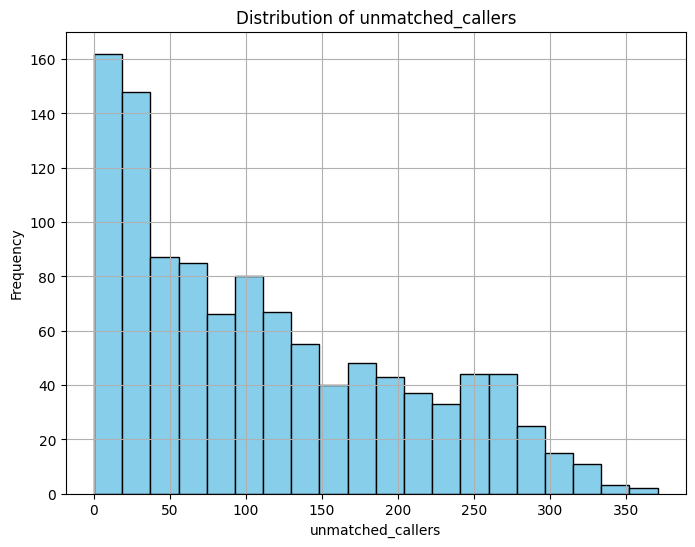

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(merged_calls_occupancy_flow_daily['unmatched_callers'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of unmatched_callers')
plt.xlabel('unmatched_callers')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


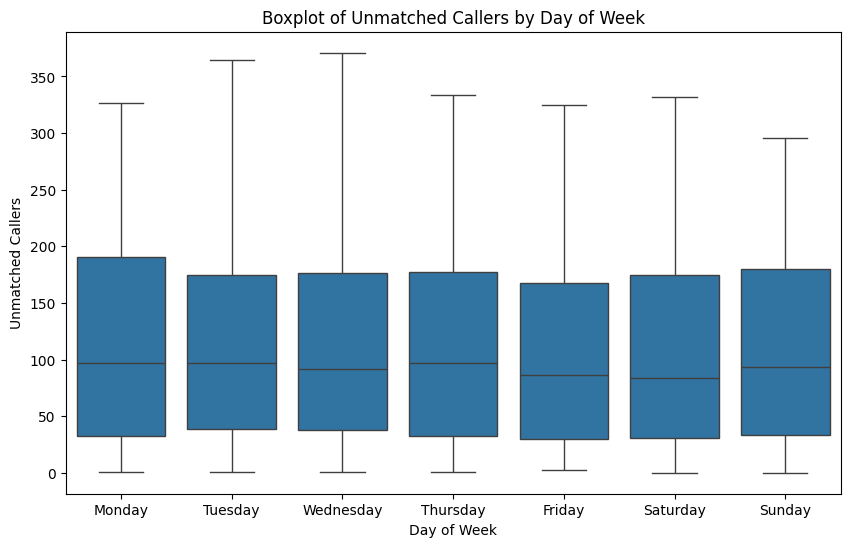

In [502]:
weather_calls_occupancy_flow_daily = pd.merge(merged_calls_occupancy_flow_daily, weather, left_index=True, right_index=True, how='left')

weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'] = weather_calls_occupancy_flow_daily['total_calls_handled'].shift(1)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='unmatched_callers', data=weather_calls_occupancy_flow_daily, order=sorted(weather_calls_occupancy_flow_daily['day_of_week'].unique()))
plt.title('Boxplot of Unmatched Callers by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Unmatched Callers')

plt.xticks(range(len(day_order)), day_order)

plt.show()

We need to focus on Motel/Hotel type of shelters since they have adjustable capacity. Let's calculate averate daily capacity for for these.

In [ ]:
concatenated_occupancy_flexible = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Motel/Hotel Shelter'].copy()

grouped_unflexible = concatenated_occupancy_flexible.groupby('Date').agg({'capacity': 'sum', 'occupancy_rate': 'mean'})

average_daily_capacity = grouped_unflexible.resample('MS').mean().rename(columns={'capacity': 'average_daily_adjustable_capacity', 'occupancy_rate': 'average_daily_occupancy_rate_adjustable'}).round(2)

capacity_adjustable_shelter = average_daily_capacity['average_daily_adjustable_capacity'].mean()

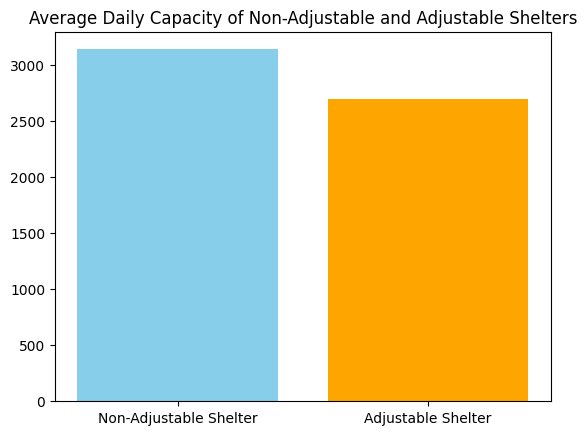

In [ ]:
bar_positions = [0, 1]
bar_heights = [capacity_non_adjustable_shelter, capacity_adjustable_shelter]
bar_colors = ['skyblue', 'orange']

plt.bar(bar_positions, bar_heights, color=bar_colors)
plt.xticks(bar_positions, ['Non-Adjustable Shelter', 'Adjustable Shelter'])

plt.title('Average Daily Capacity of Non-Adjustable and Adjustable Shelters')
plt.show()

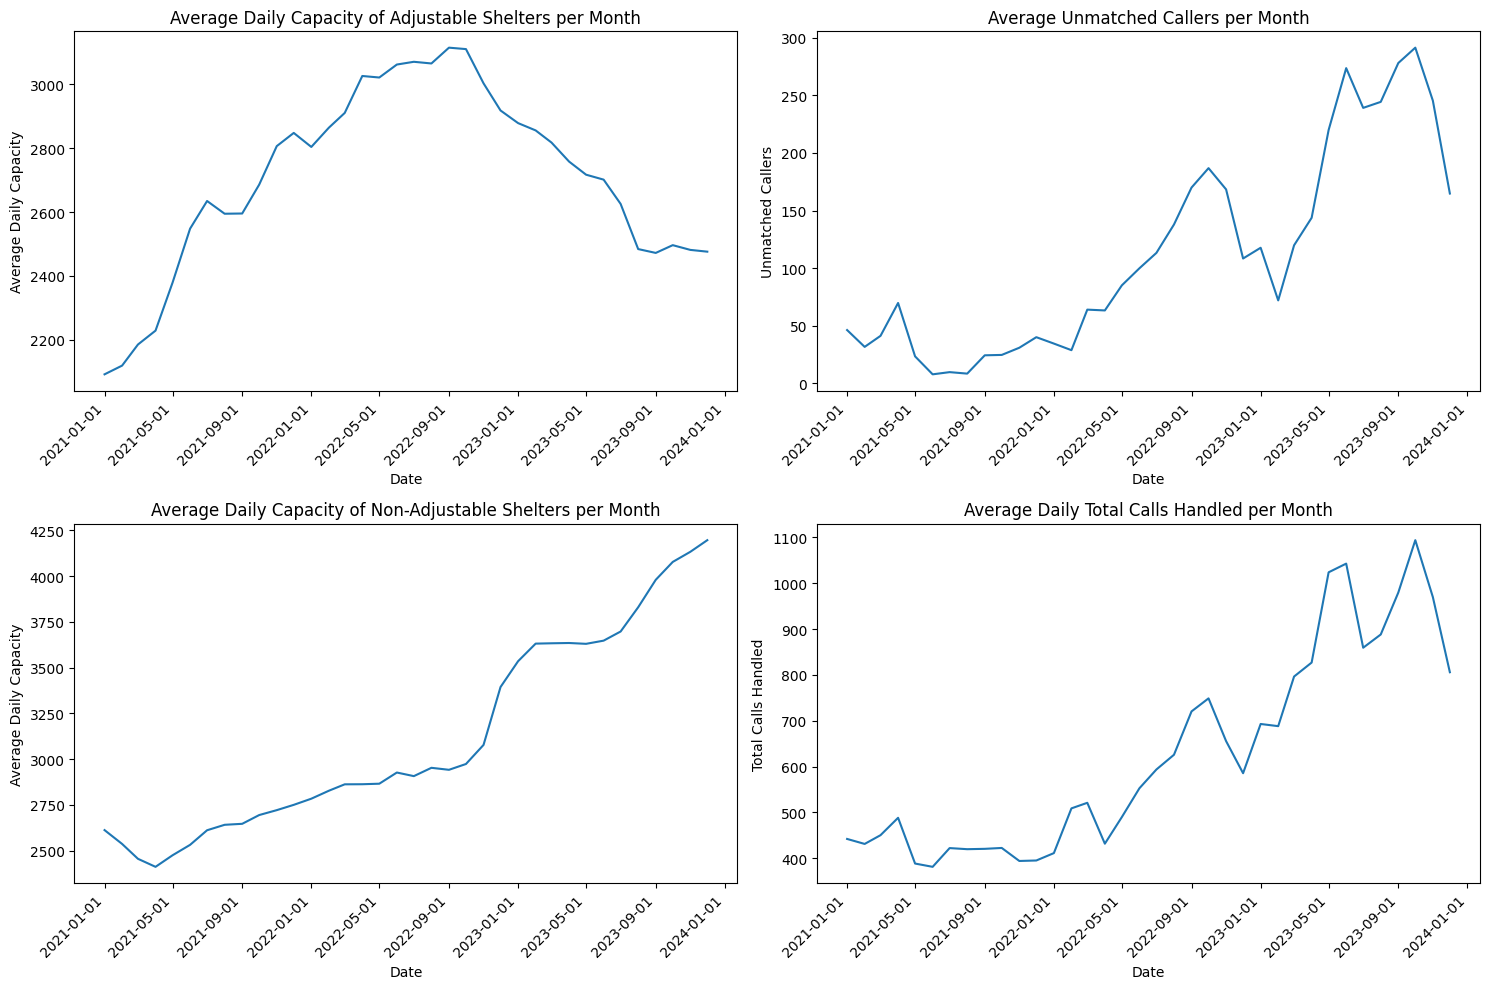

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

plt.subplot(2, 2, 1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot1 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_adjustable_capacity')
    plot1.set_xticks(plot1.get_xticks())  # Set the x-axis tick positions
    plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Adjustable Shelters per Month')

plt.subplot(2, 2, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot2 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_unmatched_callers')
    plot2.set_xticks(plot2.get_xticks())  # Set the x-axis tick positions
    plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Unmatched Callers')
plt.title('Average Unmatched Callers per Month')

plt.subplot(2, 2, 3)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot3 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_nonadjustable_capacity')
    plot3.set_xticks(plot3.get_xticks())  # Set the x-axis tick positions
    plot3.set_xticklabels(plot3.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Non-Adjustable Shelters per Month')

plt.subplot(2, 2, 4)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot4 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_total_calls')
    plot4.set_xticks(plot4.get_xticks())  # Set the x-axis tick positions
    plot4.set_xticklabels(plot4.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Total Calls Handled')
plt.title('Average Daily Total Calls Handled per Month')

plt.tight_layout()
plt.show()

# T-tests

average_daily_total_calls: 
t-statistic: -6.88893413600925
p-value: 1.7353481576535172e-07 

average_daily_unmatched_callers: 
t-statistic: -4.61201517413596
p-value: 8.006545614428855e-05 

newly_identified: 
t-statistic: 0.16602987177514428
p-value: 0.8693265141990705 

became_inactive: 
t-statistic: -5.459332384784218
p-value: 7.913462469177361e-06 

returned_to_shelter: 
t-statistic: 9.903443022198156
p-value: 1.1918615747542516e-10 

average_daily_occupancy_rate_adjustable: 
t-statistic: -0.44383746320281786
p-value: 0.6605712129084421 



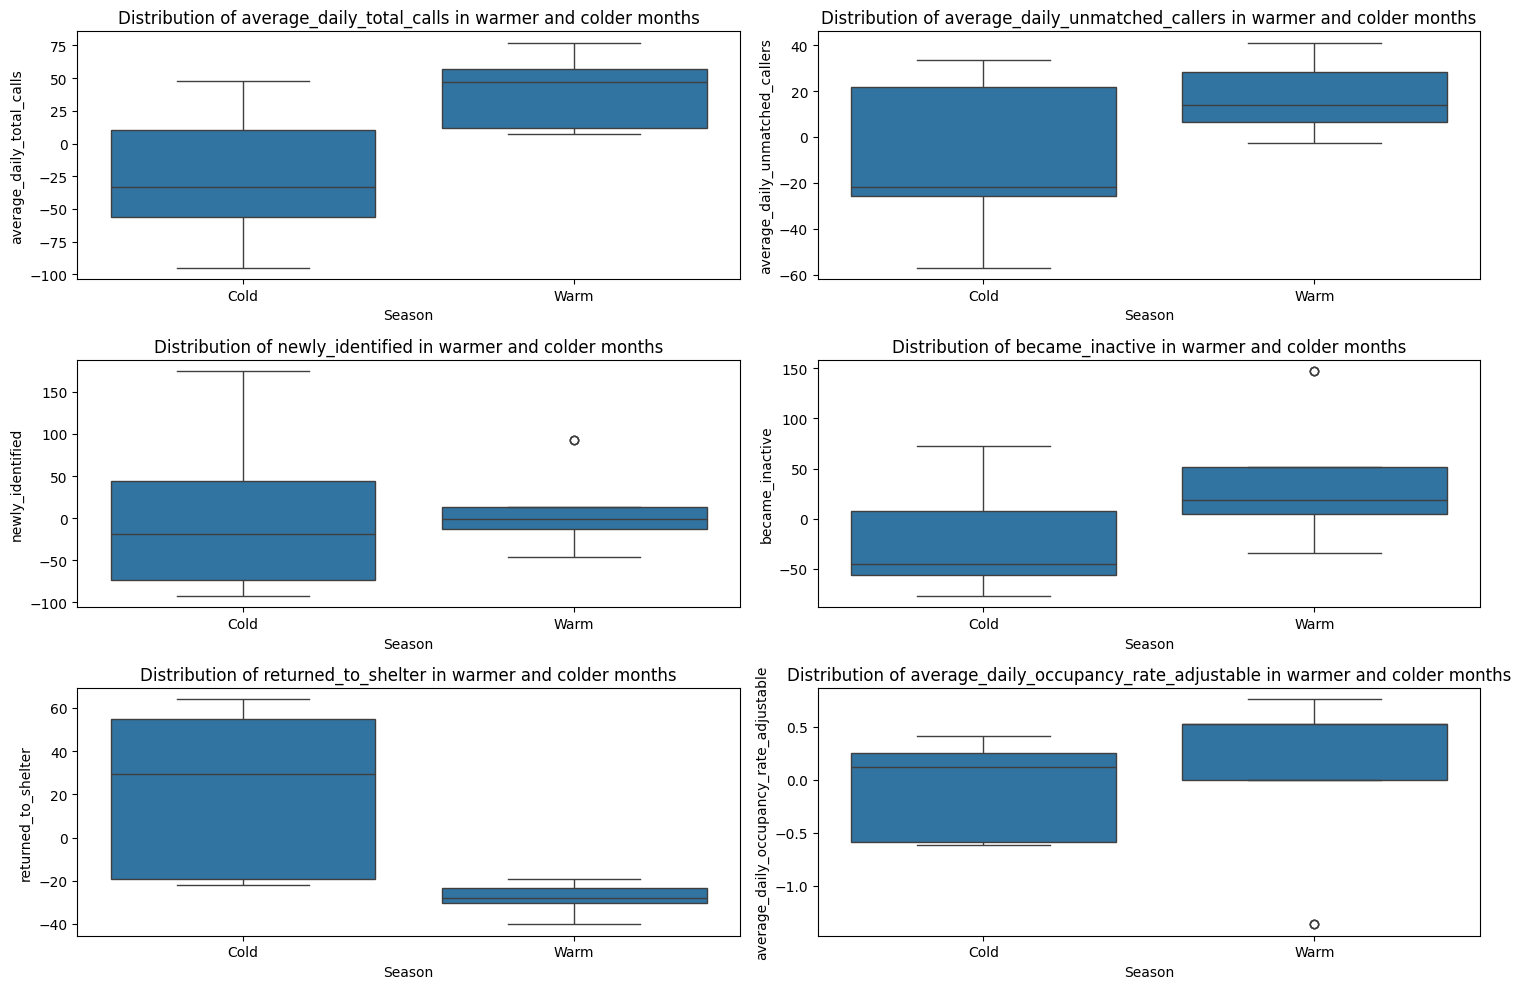

In [ ]:
variables = ['average_daily_total_calls', 'average_daily_unmatched_callers', 'newly_identified', 'became_inactive', 'returned_to_shelter', 'average_daily_occupancy_rate_adjustable']

fig, axes = plt.subplots(3, 2, figsize=(15, 10))

axes = axes.flatten()

for i, variable in enumerate(variables):

    result = seasonal_decompose(merged_calls_occupancy_flow_monthly[variable])
    seasonal_data = pd.DataFrame({variable: result.seasonal})
    seasonal_data['Month'] = seasonal_data.index.month

    cold_months = [11, 12, 1, 2,3]
    warm_months = [5, 6, 7, 8,9]

    winter_values = seasonal_data[seasonal_data['Month'].isin(cold_months)][variable]
    summer_values = seasonal_data[seasonal_data['Month'].isin(warm_months)][variable]

    t_statistic, p_value = ttest_ind(winter_values, summer_values)

    seasonal_data['Season'] = np.where(seasonal_data['Month'].isin(warm_months), 'Warm', 'Cold')
    seasonal_data['Season'] = np.where(seasonal_data['Month'].isin(cold_months), 'Cold', seasonal_data['Season'])

    sns.boxplot(x='Season', y=variable, data=seasonal_data, order=['Cold', 'Warm'], ax=axes[i])
    axes[i].set_title(f'Distribution of {variable} in warmer and colder months')

    print(f"{variable}: \nt-statistic: {t_statistic}")
    print("p-value:", p_value, "\n")

plt.tight_layout()
plt.show()

The inflow of newly identified homeless people is approximately the same both in winter and summer. However, we can recognize a pattern of outflow and inflow of people who have used shelters at least once in warm and cold months respectively. That can explain the seasonal fluctuations in the number of actively homeless people.

Otherwise, seasonality can be associated the demand for shelters, albeit in an unexpected manner: we observe more calls made in warmer months compared to colder months. Similarly, the higher number of people get refused a shelter bed during the warmer months compared to winter months.

The disadvantage we have with this merged dataset is the limited number of datapoints due to the short history (only 3 years) of data collection, which results in only 36 monthly observations. 

# Feature Engineering 

In [446]:
merged_calls_daily = pd.merge(calls, calls_full, on = 'Date', how='inner')
merged_calls_daily = merged_calls_daily[['unmatched_callers', 'total_calls_handled']]

daily_average_occupancy_rate = concatenated_occupancy.groupby(concatenated_occupancy.index.date)['occupancy_rate'].mean().round(2)

merged_calls_occupancy_daily = pd.merge(daily_average_occupancy_rate, merged_calls_daily, left_index=True, right_index=True, how='inner')

merged_calls_occupancy_daily['cold_season'] = merged_calls_occupancy_daily.index.month.isin([11, 12, 1, 2, 3]).astype(int)

shelter_flow = shelter_flow[['returned_from_housing','returned_to_shelter', 'newly_identified', 'became_inactive']]

shelter_flow_daily = shelter_flow.resample('D').ffill()

shelter_flow_daily.index = pd.to_datetime(shelter_flow_daily.index)

merged_calls_occupancy_flow_daily = pd.merge(merged_calls_occupancy_daily, shelter_flow_daily, left_index=True, right_index=True, how='left')

merged_calls_occupancy_flow_daily.reset_index(inplace=True)
merged_calls_occupancy_flow_daily.ffill(inplace=True)
first_columns_to_int = ['returned_from_housing','returned_to_shelter', 'newly_identified', 'became_inactive']
merged_calls_occupancy_flow_daily[first_columns_to_int] = merged_calls_occupancy_flow_daily[first_columns_to_int].astype(int)

merged_calls_occupancy_flow_daily = merged_calls_occupancy_flow_daily.rename(columns={'index': 'Date'})
merged_calls_occupancy_flow_daily = merged_calls_occupancy_flow_daily.set_index('Date')

Assume that temperature can be forecasted a day prior, and occupancy_rate cannot. That means, we need to add a day-lag to occupancy_rate.

In [500]:
weather_calls_occupancy_flow_daily = pd.merge(merged_calls_occupancy_flow_daily, weather, left_index=True, right_index=True, how='left')

weather_calls_occupancy_flow_daily.index.freq = 'D'

weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'] = weather_calls_occupancy_flow_daily['unmatched_callers'].shift(1)
weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'].ffill()

weather_calls_occu pancy_flow_daily['unmatched_callers_lag_twodays'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_day'].shift(1)
weather_calls_occupancy_flow_daily['unmatched_callers_lag_twodays'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_twodays'].ffill()

weather_calls_occupancy_flow_daily['unmatched_callers_lag_week'] = weather_calls_occupancy_flow_daily['unmatched_callers'].shift(7)
weather_calls_occupancy_flow_daily['unmatched_callers_lag_week'] = weather_calls_occupancy_flow_daily['unmatched_callers_lag_week'].ffill()

weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'] = weather_calls_occupancy_flow_daily['occupancy_rate'].shift(1)
weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'] = weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'].ffill()
weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'] = weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'].bfill()
weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'] = np.log(weather_calls_occupancy_flow_daily['occupancy_rate_lag_day'])

weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'] = weather_calls_occupancy_flow_daily['total_calls_handled'].shift(1)
weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'] = weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'].ffill()
weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'] = weather_calls_occupancy_flow_daily['total_calls_handled_lag_day'].bfill()

weather_calls_occupancy_flow_daily = weather_calls_occupancy_flow_daily.drop(['total_calls_handled', 'occupancy_rate', 'day_of_week', 'day_1', 
'day_2', 'day_3', 'day_4', 'day_5', 'day_6'], axis=1)

weather_calls_occupancy_flow_daily.dropna(inplace=True)

In [501]:
weather_calls_occupancy_flow_daily.head()

,unmatched_callers,cold_season,returned_from_housing,returned_to_shelter,newly_identified,became_inactive,min_temp_cels,total_precip_mm,unmatched_callers_lag_day,unmatched_callers_lag_twodays,unmatched_callers_lag_week,occupancy_rate_lag_day,total_calls_handled_lag_day
Date,,,,,,,,,,,,,
2021-01-08,64,1,84,425,647,660,-9.3,0.0,30.0,39.0,19.0,4.525261,440.0
2021-01-09,70,1,84,425,647,660,-4.3,0.0,64.0,30.0,22.0,4.533782,475.0
2021-01-10,74,1,84,425,647,660,-5.6,0.0,70.0,64.0,28.0,4.535391,506.0
2021-01-11,75,1,84,425,647,660,-6.1,0.0,74.0,70.0,28.0,4.531201,477.0
2021-01-12,80,1,84,425,647,660,-2.1,0.0,75.0,74.0,45.0,4.532492,529.0


# ARIMA model

In [449]:
weather_calls_occupancy_flow_daily = pd.merge(merged_calls_occupancy_flow_daily, weather, left_index=True, right_index=True, how='left')
weather_calls_occupancy_flow_daily.head()

,occupancy_rate,unmatched_callers,total_calls_handled,cold_season,returned_from_housing,returned_to_shelter,newly_identified,became_inactive,min_temp_cels,total_precip_mm,day_of_week,day_1,day_2,day_3,day_4,day_5,day_6
Date,,,,,,,,,,,,,,,,,
2021-01-01,92.83,19,305,1,84,425,647,660,-4.1,8.0,4,0,0,0,1,0,0
2021-01-02,92.99,22,319,1,84,425,647,660,-2.5,6.8,5,0,0,0,0,1,0
2021-01-03,92.64,28,281,1,84,425,647,660,-0.8,1.6,6,0,0,0,0,0,1
2021-01-04,92.15,28,379,1,84,425,647,660,-0.8,0.0,0,0,0,0,0,0,0
2021-01-05,92.06,45,461,1,84,425,647,660,-0.1,0.2,1,1,0,0,0,0,0


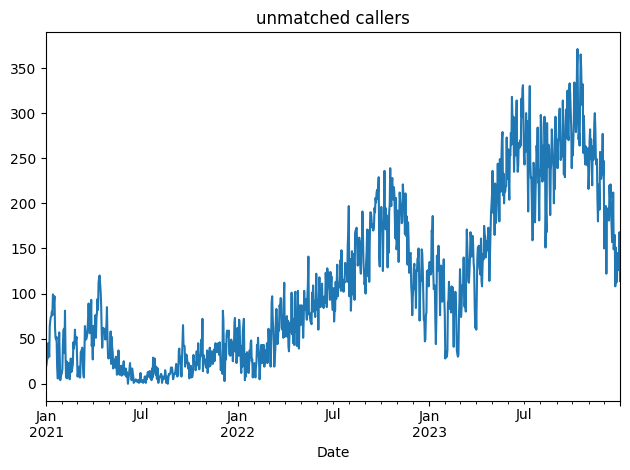

In [450]:
weather_calls_occupancy_flow_daily.unmatched_callers.plot(title='unmatched callers')
plt.tight_layout(); plt.show()

In [451]:
result = adfuller(weather_calls_occupancy_flow_daily.unmatched_callers)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.2345176212828834
p-value: 0.6585737040510949


As can be deduced from the time-series plot, the variable is non-stationary: both linear trend and seasonality is observed. This is proved by Adfuller stationarity test as well. Need to do differencing to get rid of linear trend.

In [452]:
diff_unmatched_callers = weather_calls_occupancy_flow_daily['unmatched_callers'].diff().dropna()

# Perform the Augmented Dickey-Fuller test on the differenced data
result = adfuller(diff_unmatched_callers, regression='ct')
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -8.345240926376022
p-value: 1.1393582206599506e-11


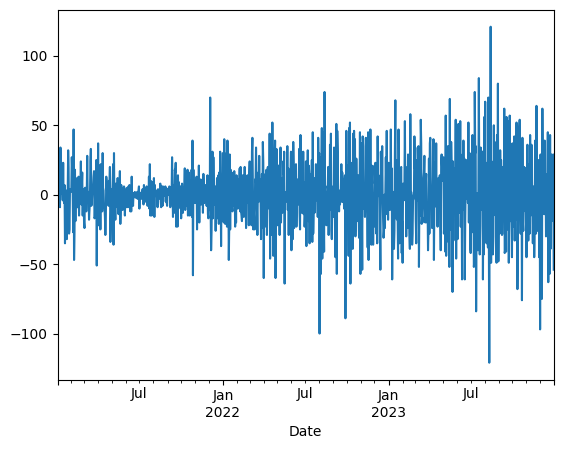

In [453]:
diff_unmatched_callers.plot()
plt.show()

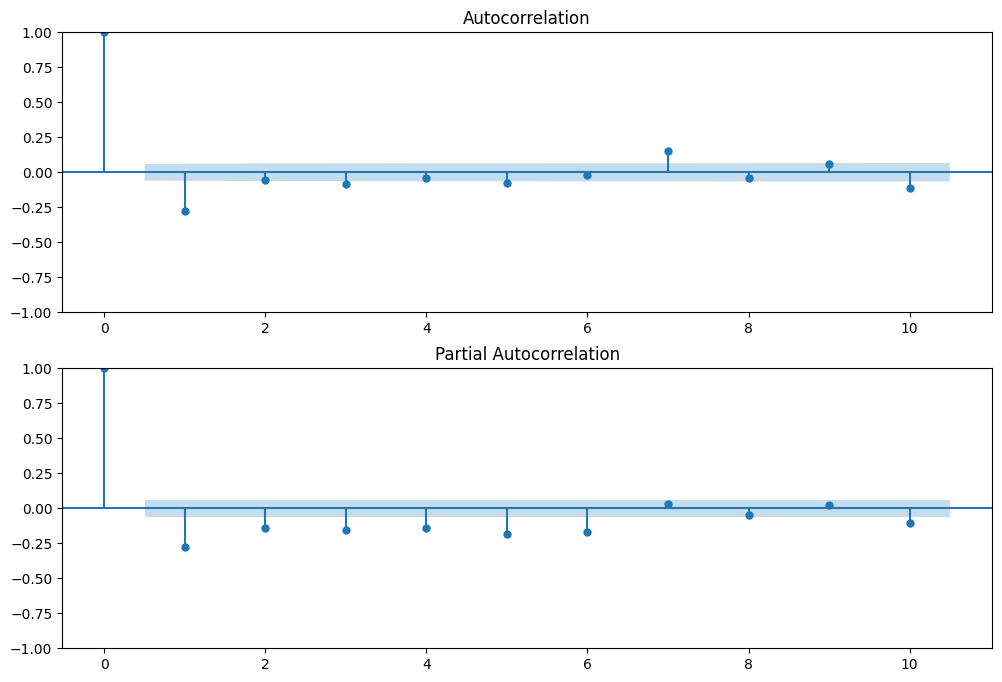

In [454]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
plot_acf(diff_unmatched_callers, lags=10, ax=ax1)

# Plot the PACF of df
plot_pacf(diff_unmatched_callers, lags=10,  ax=ax2)

plt.show()


In [455]:
weather_calls_occupancy_flow_daily.index.freq = 'D'

order_aic_bic = []

for p in range(5):
    for q in range(5):
        try:
            try_model = ARIMA(weather_calls_occupancy_flow_daily.unmatched_callers, order=(p, 1, q), freq='D')
            try_results = try_model.fit()

            order_aic_bic.append((p, q, try_results.aic, try_results.bic))

        except Exception as e:
            print(f"Error for p={p}, q={q}: {e}")
            order_aic_bic.append((p, q, None, None))

order_aic_bic = pd.DataFrame(order_aic_bic, columns=['AR', 'MA', 'AIC', 'BIC'])
top_models = order_aic_bic.dropna().sort_values(by='BIC').head(5)
print(top_models)


    AR  MA          AIC          BIC
18   3   3  9920.267005  9955.250177
24   4   4  9916.713538  9961.691902
6    1   1  9958.362803  9973.355591
13   2   3  9945.130318  9975.115893
3    0   3  9959.128894  9979.119278


In [456]:
model_arima = ARIMA(weather_calls_occupancy_flow_daily.unmatched_callers, order=(3,1,3))
results_arima = model_arima.fit()

predictions_arima = results_arima.predict()

mae_arima = mean_absolute_error(weather_calls_occupancy_flow_daily.unmatched_callers, predictions_arima)

print(f'Mean Absolute Error (MAE): {mae_arima}')
print(results_arima.bic)

Mean Absolute Error (MAE): 16.690393971632638
9955.250177345364


In [457]:
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:      unmatched_callers   No. Observations:                 1095
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -4953.134
Date:                Sat, 09 Mar 2024   AIC                           9920.267
Time:                        23:57:33   BIC                           9955.250
Sample:                    01-01-2021   HQIC                          9933.505
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4515      0.054     26.929      0.000       1.346       1.557
ar.L2         -1.2734      0.068    -18.686      0.000      -1.407      -1.140
ar.L3          0.2704      0.050      5.379      0.0

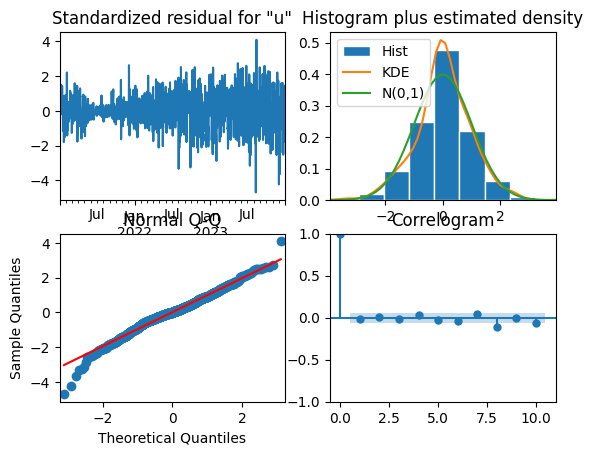

In [458]:
results_arima.plot_diagnostics()
plt.show()

# Rolling ARIMA's predictions

In [481]:
cutoff_date = pd.to_datetime('2023-01-01')
train_data = weather_calls_occupancy_flow_daily[:cutoff_date]
test_data = weather_calls_occupancy_flow_daily[cutoff_date:]

In [461]:
history_arima = train_data['unmatched_callers'].tolist()

predictions_arima_rolling = []

for t in range(len(test_data)):
    model_arima_rolling = ARIMA(history_arima, order=(3,1,3))
    model_fit = model_arima_rolling.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima_rolling.append(yhat)
    
    obs = test_data.iloc[t]['unmatched_callers']
    history_arima.append(obs)

mae_arima_rolling = mean_absolute_error(test_data['unmatched_callers'], predictions_arima_rolling)
print(f"ARIMA's MAE on the test data: {mae_arima_rolling:.3f}")

ARIMA's MAE on the test data: 23.009


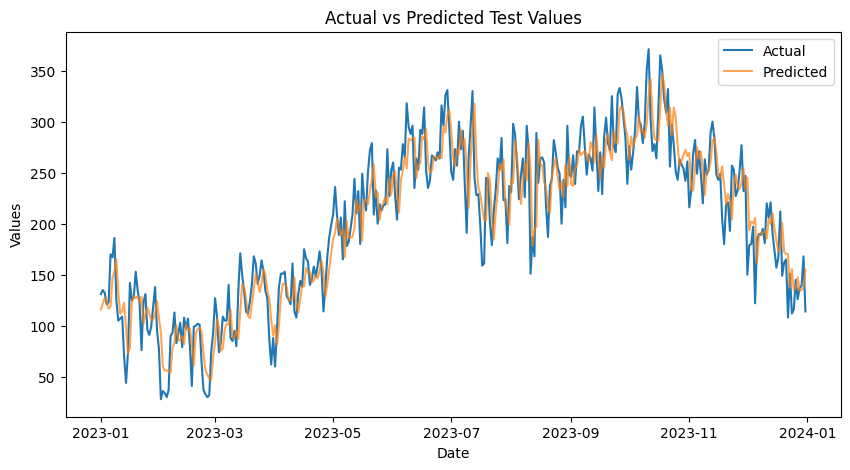

In [462]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data.unmatched_callers, label='Actual')
plt.plot(test_data.index, predictions_arima_rolling, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Test Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

# SARIMAX model tuning

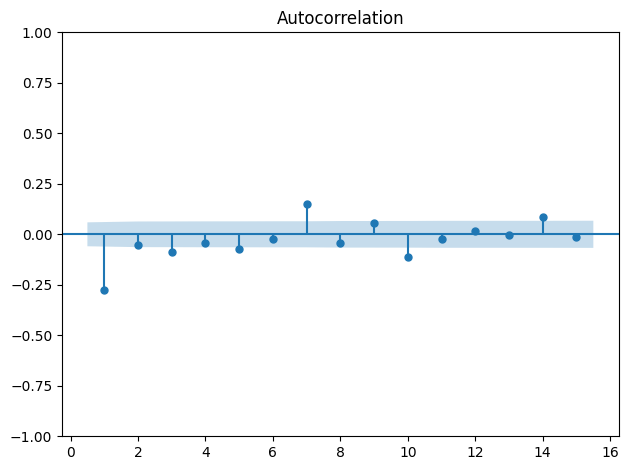

In [463]:
lags = [1,7,14,21,28]

plot_acf(diff_unmatched_callers, lags=15, zero=False)
ax1.set_title('Autocorrelation Function (ACF)')

plt.tight_layout()
plt.show()


We observe weekly seasonality

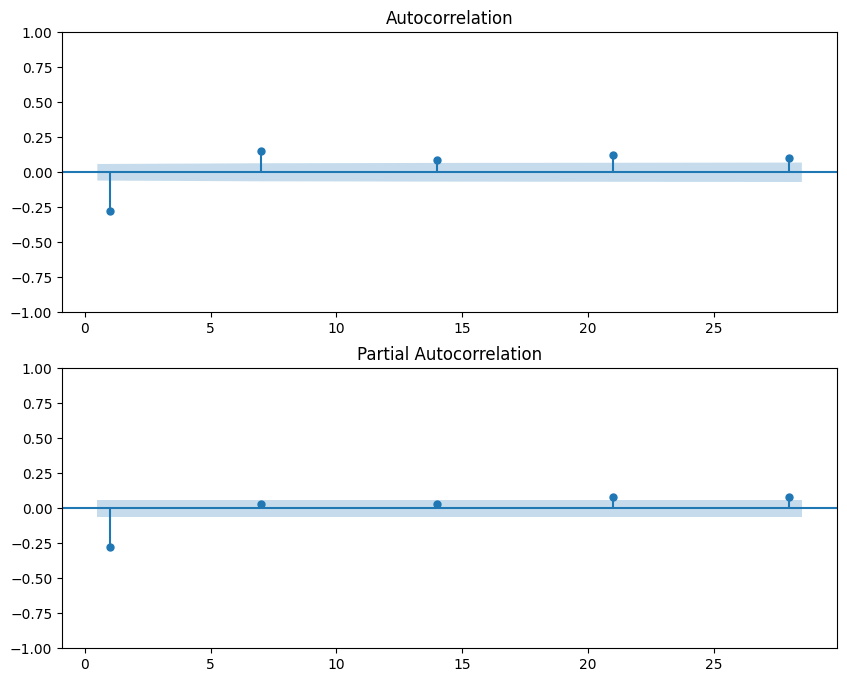

In [464]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

plot_acf(diff_unmatched_callers, lags = lags, ax = ax1)
plot_pacf(diff_unmatched_callers, lags = lags, ax = ax2)

plt.show()

What is the best set of sarimax parameters and exogenous variables?


In [465]:
model_auto = pm.auto_arima(weather_calls_occupancy_flow_daily.unmatched_callers,
                        seasonal=True, m=7,
                        d=1, D=1,
                        max_p=2, max_q=2,
                        error_action='ignore',
                        suppress_warnings=True)

print(model_auto.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1095
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood               -4937.506
Date:                                Sun, 10 Mar 2024   AIC                           9889.013
Time:                                        00:02:42   BIC                           9923.951
Sample:                                    01-01-2021   HQIC                          9902.238
                                         - 12-31-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4559      0.037     12.385      0.000       0.384       0.528
ar.

In [466]:
model_sarima = SARIMAX(weather_calls_occupancy_flow_daily.unmatched_callers,  
                       order=(2, 1, 1), 
                       seasonal_order=(1, 0, 1, 7))

results_sarima = model_sarima.fit(disp=0)
predictions_sarima = results_sarima.predict()

mae_sarima = mean_absolute_error(weather_calls_occupancy_flow_daily.unmatched_callers, predictions_sarima)

print("SARIMA's MAE: {}".format(mae_sarima.round(2)))
print('MAE improved: {}%'.format((100*((mae_arima - mae_sarima)/mae_arima)).round(2)))
print('BIC improved: {}%'.format((100*((results_arima.bic - results_sarima.bic)/results_arima.bic)).round(2)))

SARIMA's MAE: 16.67
MAE improved: 0.11%
BIC improved: 0.17%


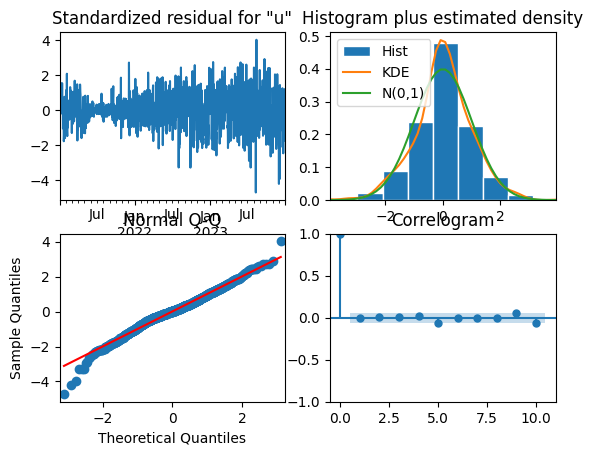

In [467]:
results_sarima.plot_diagnostics()
plt.show()

In [468]:
history_sarima = train_data['unmatched_callers'].tolist()
predictions_sarima_rolling = list()

for t in range(len(test_data)):
    model_sarima_rolling = SARIMAX(history_sarima, order=(2,1,1), seasonal_order=(1,0,1,7))
    model_fit = model_sarima_rolling.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_sarima_rolling.append(yhat)
    obs = test_data.iloc[t]['unmatched_callers']
    history_sarima.append(obs)

mae_sarima_rolling = mean_absolute_error(test_data.unmatched_callers, predictions_sarima_rolling)
print("SARIMA's MAE on the test data: %.3f" % mae_sarima_rolling)


SARIMA's MAE on the test data: 22.684


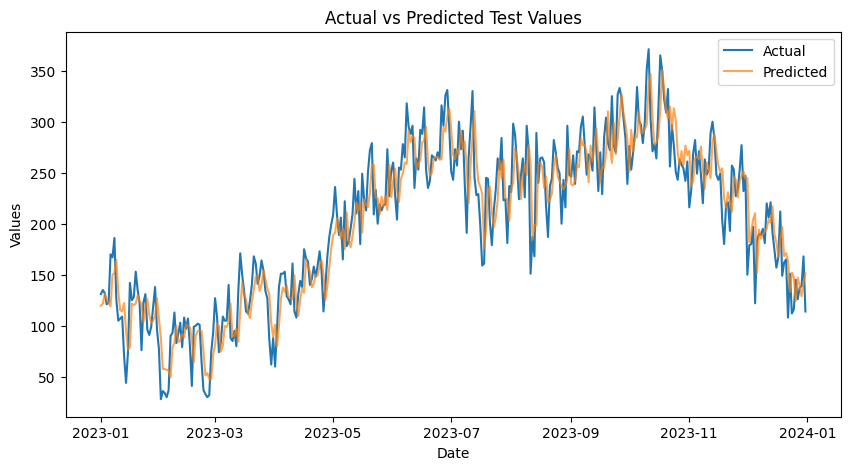

In [469]:
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data.unmatched_callers, label='Actual')
plt.plot(test_data.index, predictions_sarima_rolling, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Test Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [473]:
weather_calls_occupancy_flow_daily.head()

,occupancy_rate,unmatched_callers,total_calls_handled,cold_season,returned_from_housing,returned_to_shelter,newly_identified,became_inactive,min_temp_cels,total_precip_mm,day_of_week,day_1,day_2,day_3,day_4,day_5,day_6
Date,,,,,,,,,,,,,,,,,
2021-01-01,92.83,19,305,1,84,425,647,660,-4.1,8.0,4,0,0,0,1,0,0
2021-01-02,92.99,22,319,1,84,425,647,660,-2.5,6.8,5,0,0,0,0,1,0
2021-01-03,92.64,28,281,1,84,425,647,660,-0.8,1.6,6,0,0,0,0,0,1
2021-01-04,92.15,28,379,1,84,425,647,660,-0.8,0.0,0,0,0,0,0,0,0
2021-01-05,92.06,45,461,1,84,425,647,660,-0.1,0.2,1,1,0,0,0,0,0


In [495]:
endog = weather_calls_occupancy_flow_daily.unmatched_callers

columns_to_exclude = ['unmatched_callers', 'total_calls_handled', 'unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'unmatched_callers_lag_twodays']
columns_to_include = [col for col in weather_calls_occupancy_flow_daily.columns if col not in columns_to_exclude]

exog_features = weather_calls_occupancy_flow_daily[columns_to_include].copy()
feature_names = exog_features.columns

best_feature = None

best_bic = float('inf')
current_features = []

while True:
    improvement = False
    for feature in exog_features.columns.difference(current_features):
        try:
            model = SARIMAX(endog, exog=exog_features[current_features + [feature]], 
                            order=(2,1,1), seasonal_order=(1,0,1,7), enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=0)

            if results.bic < best_bic:
                best_bic = results.bic
                best_feature = feature
                improvement = True
        except:
            continue

    if improvement:
        current_features.append(best_feature)
        print(f"Added {best_feature}, BIC: {best_bic}")
    else:
        break

print(f"Final features: {current_features}")

Added min_temp_cels, BIC: 9795.19679902407
Final features: ['min_temp_cels']


In [497]:
current_features.append('occupancy_rate_lag_day')
print(current_features)

['min_temp_cels', 'occupancy_rate_lag_day']


In [477]:
model_sarima = SARIMAX(weather_calls_occupancy_flow_daily.unmatched_callers,  
                       exog = weather_calls_occupancy_flow_daily[current_features],
                       order=(2, 1, 1), 
                       seasonal_order=(1, 1, 1, 7))

results_sarima = model_sarima.fit(disp=0)
predictions_sarima = results_sarima.predict()

mae_sarima = mean_absolute_error(weather_calls_occupancy_flow_daily.unmatched_callers, predictions_sarima)
print("SARIMA's MAE: {}".format(mae_sarima.round(4)))

SARIMA's MAE: 17.3513


In [478]:
print(results_sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                 unmatched_callers   No. Observations:                 1088
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4896.403
Date:                           Sun, 10 Mar 2024   AIC                           9808.806
Time:                                   00:39:35   BIC                           9848.684
Sample:                               01-08-2021   HQIC                          9823.906
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
min_temp_cels              0.9307      0.205      4.530      0.000       0.528       1.333
occupan

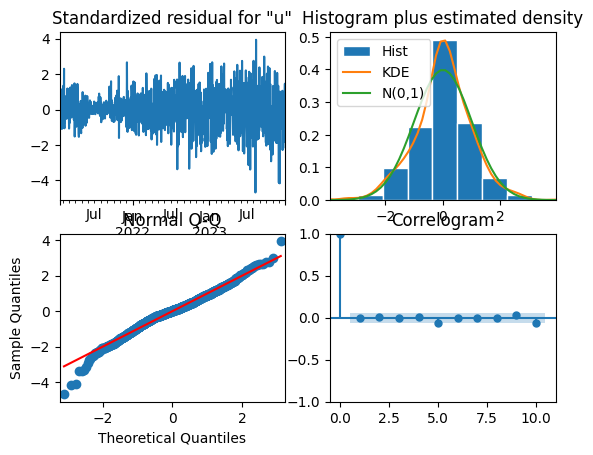

In [479]:
results_sarima.plot_diagnostics()
plt.show()

In [496]:
train_endog = train_data['unmatched_callers']
test_sarimax = test_data['unmatched_callers']
train_exog = train_data[current_features]
test_exog = test_data[current_features]

history_endog = [x for x in train_endog]
history_exog = train_exog.values.tolist()  
predictions_sarimax = []

for t in range(len(test_sarimax)):
    model = SARIMAX(history_endog, exog=history_exog,
                    order=(2, 1, 1),  
                    seasonal_order=(1, 0, 1, 7))
    model_fit = model.fit(disp = 0)
    
    next_exog = test_exog.iloc[t:t+1].values  
    
    output = model_fit.forecast(exog=next_exog)
    yhat = output[0]
    predictions_sarimax.append(yhat)
    
    obs = test_sarimax.iloc[t]
    history_endog.append(obs)

    history_exog.append(next_exog[0].tolist())  

mae_sarimax = mean_absolute_error(test_sarimax, predictions_sarimax)
print("Mean Absolute Error (MAE) on test data:", mae_sarimax)

Mean Absolute Error (MAE) on test data: 22.780244673069703


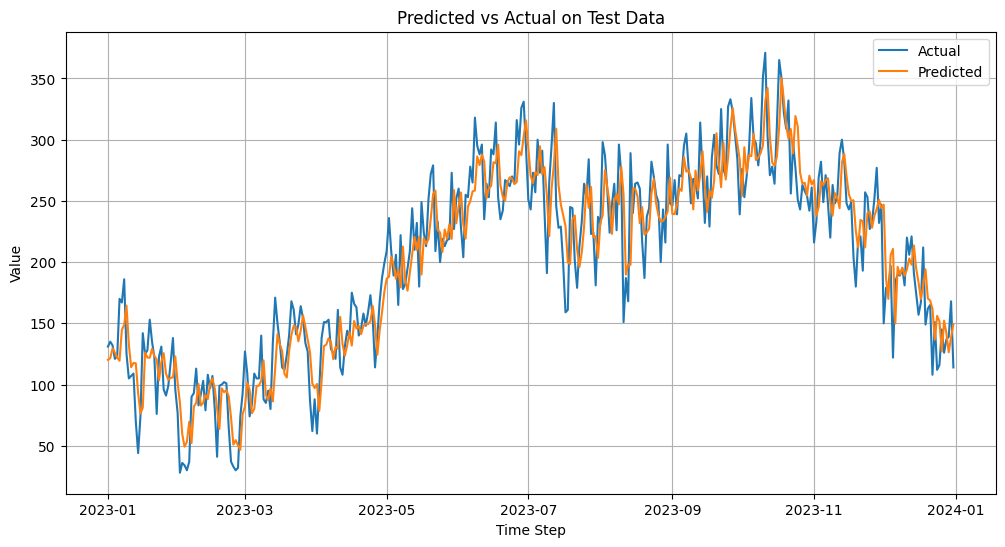

In [484]:
plt.figure(figsize=(12, 6))
plt.plot(test_sarimax.index, test_sarimax, label='Actual')
plt.plot(test_sarimax.index, predictions_sarimax, label='Predicted')
plt.title('Predicted vs Actual on Test Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# OTHER MODELS

# Linear Regression

In [486]:
initial_features = ['occupancy_rate_lag_day',
       'cold_season', 'returned_from_housing', 'returned_to_shelter',
       'newly_identified', 'became_inactive', 'min_temp_cels',
       'total_precip_mm', 'day_of_week',
       'total_calls_handled_lag_day', 'total_calls_handled_lag_day',
       'unmatched_callers_lag_week', 'unmatched_callers_lag_day', 'unmatched_callers_lag_twodays']

history_y = train_data['unmatched_callers'].values
selected_features = []

best_mae = np.inf
improvement = True

while improvement:
    improvement = False
    for feature in initial_features:
        if feature not in selected_features:
            # Try adding this feature
            temp_features = selected_features + [feature]
            
            # Reinitialize history_X with the current set of features
            history_X = train_data[temp_features]
            
            predictions_temp = []
            for t in range(len(test_data)):
                # Note: In a real rolling forecast, you'd retrain here with the growing history_X
                # For simplicity, we're training once per iteration before the loop for demonstration
                model_temp = LinearRegression().fit(history_X, history_y)
                
                next_row = test_data.iloc[[t]]
                next_X = next_row[temp_features]
                yhat = model_temp.predict(next_X)[0]
                predictions_temp.append(yhat)
            
            temp_mae = mean_absolute_error(test_data['unmatched_callers'], predictions_temp)
            
            # Check if the temporary feature set gives better performance
            if temp_mae < best_mae:
                best_mae = temp_mae
                best_feature = feature
                improvement = True
    
    # If an improvement was found, update the selected features and the best MAE
    if improvement:
        selected_features.append(best_feature)
        print(f"Added {best_feature}, New best MAE: {best_mae}")

# Final selected features and performance
print(f"Selected features: {selected_features}")
print(f"Best MAE with selected features: {best_mae}")


Added unmatched_callers_lag_day, New best MAE: 25.801356184367464
Added unmatched_callers_lag_week, New best MAE: 23.878839504254184
Added unmatched_callers_lag_twodays, New best MAE: 23.52256618446129
Added returned_to_shelter, New best MAE: 23.37662083809538
Added newly_identified, New best MAE: 23.268505544945405
Added min_temp_cels, New best MAE: 23.21216988668201
Added returned_from_housing, New best MAE: 23.178817629753006
Selected features: ['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'unmatched_callers_lag_twodays', 'returned_to_shelter', 'newly_identified', 'min_temp_cels', 'returned_from_housing']
Best MAE with selected features: 23.178817629753006


In [487]:
history_X = train_data[['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'occupancy_rate_lag_day', 'unmatched_callers_lag_twodays', 'returned_to_shelter', 'newly_identified', 'min_temp_cels', 'returned_from_housing']]
history_y = train_data['unmatched_callers'].values 

predictions_linear = []

for t in range(len(test_data)):
    model_linear = LinearRegression()
    model_linear.fit(history_X, history_y)  
    
    next_row = test_data.iloc[t:t+1]  
    next_X = next_row[['unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'occupancy_rate_lag_day', 'unmatched_callers_lag_twodays', 'returned_to_shelter', 'newly_identified', 'min_temp_cels', 'returned_from_housing']]
    
    yhat = model_linear.predict(next_X)[0]  
    predictions_linear.append(yhat)  
    
    true_value = next_row['unmatched_callers'].values[0]
    history_y = np.append(history_y, true_value)  
    history_X = pd.concat([history_X, next_X], ignore_index=True)

mae_linear_rolling = mean_absolute_error(test_data.unmatched_callers, predictions_linear)
print("Mean Absolute Error (MAE) on test data with rolling forecast:", mae_linear_rolling)


Mean Absolute Error (MAE) on test data with rolling forecast: 23.129553810669353


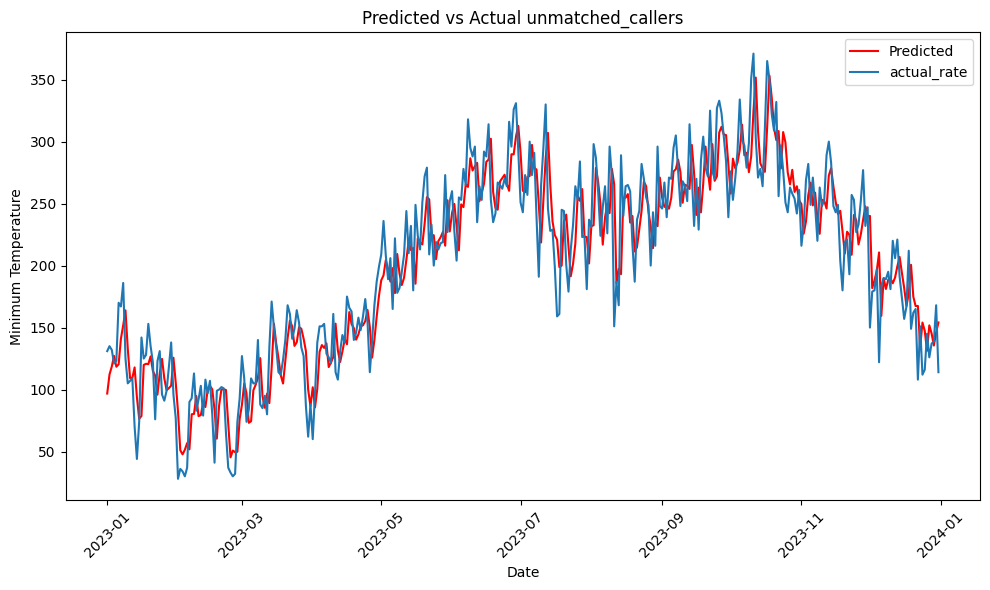

In [488]:
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, predictions_linear, label='Predicted', c= 'r')
plt.plot(test_data.index, test_data.unmatched_callers, label='actual_rate')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature')
plt.title('Predicted vs Actual unmatched_callers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Feature Importance with LGBM


In [489]:
history_X = train_data[['occupancy_rate_lag_day', 'cold_season', 'returned_from_housing', 'returned_to_shelter',
                    'newly_identified', 'became_inactive', 'min_temp_cels', 'total_precip_mm', 'unmatched_callers_lag_twodays',
                    'total_calls_handled_lag_day', 'unmatched_callers_lag_day', 'unmatched_callers_lag_week']]
history_y = train_data['unmatched_callers'].values 

predictions_lgbm = []
model_lgbm = lgb.LGBMRegressor()

for t in range(len(test_data)):
    
    model_lgbm.fit(history_X, history_y)
    
    next_row = test_data.iloc[t:t+1]
    next_X = next_row[['occupancy_rate_lag_day', 'cold_season', 'returned_from_housing', 'returned_to_shelter',
                    'newly_identified', 'became_inactive', 'min_temp_cels', 'total_precip_mm',  'unmatched_callers_lag_twodays',
                    'total_calls_handled_lag_day', 'unmatched_callers_lag_day', 'unmatched_callers_lag_week']]
    
    yhat = model_lgbm.predict(next_X)[0]
    predictions_lgbm.append(yhat)
    
    true_value = next_row['unmatched_callers'].values[0]
    history_y = np.append(history_y, true_value)
    # Correctly append the next_X row to history_X
    history_X = pd.concat([history_X, next_X], ignore_index=True)

mae_lgbm_rolling = mean_absolute_error(test_data['unmatched_callers'], predictions_lgbm)
print("Mean Absolute Error (MAE) on test data with rolling forecast using LightGBM:", mae_lgbm_rolling)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 723, number of used features: 13
[LightGBM] [Info] Start training from score 68.015214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

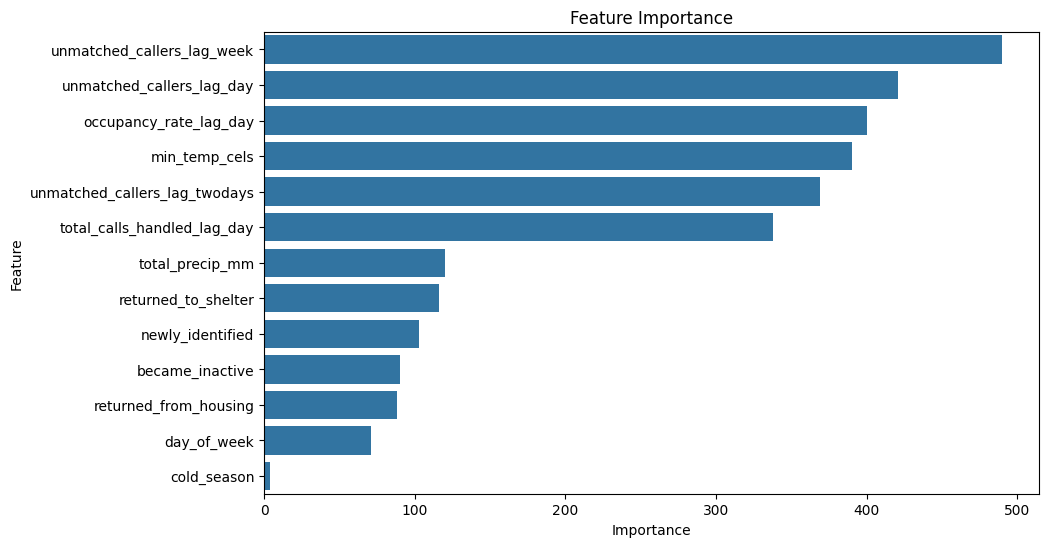

In [490]:
feature_importances = model_lgbm.feature_importances_

feature_names = history_X.columns.tolist()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Fitting LGBM 

In [491]:
history_X = train_data[['occupancy_rate_lag_day', 'min_temp_cels', 'total_calls_handled_lag_day', 'unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'unmatched_callers_lag_twodays']]
history_y = train_data['unmatched_callers'].values 

predictions_lgbm = []
model_lgbm = lgb.LGBMRegressor()

for t in range(len(test_data)):
    
    model_lgbm.fit(history_X, history_y)
    
    next_row = test_data.iloc[t:t+1]
    next_X = next_row[['occupancy_rate_lag_day', 'min_temp_cels','total_calls_handled_lag_day', 'unmatched_callers_lag_day', 'unmatched_callers_lag_week', 'unmatched_callers_lag_twodays']]
    
    yhat = model_lgbm.predict(next_X)[0]
    predictions_lgbm.append(yhat)
    
    true_value = next_row['unmatched_callers'].values[0]
    history_y = np.append(history_y, true_value)
    # Correctly append the next_X row to history_X
    history_X = pd.concat([history_X, next_X], ignore_index=True)

mae_lgbm_rolling = mean_absolute_error(test_data['unmatched_callers'], predictions_lgbm)
print("Mean Absolute Error (MAE) on test data with rolling forecast using LightGBM:", mae_lgbm_rolling)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 723, number of used features: 6
[LightGBM] [Info] Start training from score 68.015214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

# CONCLUSION

SARIMAX model with two exogenioius variables – min_temp_cel and occupancy_rate_lag_day – yielded the best MAE score over in predicting daily number of unmacthed_callers in 2023. 